## 【問題1】K-meansクラスの作成
非階層クラスタリングの手法であるK-meansのクラスを作成してください。名前はScratchKMeansとしてください。

教師なし学習であるクラスタリングになるため、ここまでの回帰や分類とは異なるパイプラインを作成することになります。

メソッドやパラメータなどはscikit-learnを参考にしてください。

sklearn.cluster.KMeans — scikit-learn 0.20.0 documentation

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。

クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しました。スクラッチの過程で利用してください。

このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 _（アンダースコア） で受け取っています。

SSE (Sum of squared errors)は以下で表される。
$$
SSE = \sum_{n=1}^{N}\sum_{k=1}^{K}r_{nk}||X_{n}-\mu_{k}||^{2}
$$

$n$: index of data samples<br>
$k$: index of clusters<br>
$X_{n}$: data of n-th sample<br>
$\mu_{k}$: central point of cluster k<br>
$r_{nk}$: 1 if $X_{n}$ belongs to cluster $k$, else 0<br>


In [405]:
#テストデータ読み込み
import numpy as np
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [406]:
X[:10]

array([[ 0.72086751,  3.71347124],
       [-1.89468423,  7.96898545],
       [ 1.35678894,  4.36462484],
       [ 1.05374379,  4.49286859],
       [ 1.59141542,  4.90497725],
       [ 0.78260667,  4.15263595],
       [-1.95751686,  3.87291474],
       [-0.77354537,  7.87923564],
       [ 0.12313498,  5.27917503],
       [-1.43284669,  7.71577043]])

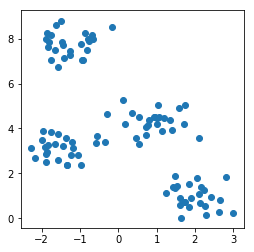

In [408]:
#dataを見てみる
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.scatter(X[:, 0], X[:, 1])

#4個っぽいのでn_neighbors = 4 としてみる
plt.show()

In [194]:
#具体例でイメージの把握をする。
#muを初期化
#n_neighbors = 5で
n_neighbors = 5

mu_idx = np.array([np.random.randint(0,X.shape[0]) for i in range(5)])
print(mu_idx)

mu = X[mu_idx] 
print(mu)

[94 19 99  9 94]
[[-2.27253281  3.13757811]
 [ 2.62496786  0.28025075]
 [-0.30022483  4.63059663]
 [-1.43284669  7.71577043]
 [-2.27253281  3.13757811]]


In [195]:
v0 = X-mu[0, :]
v1 = X-mu[1, :]
v2 = X-mu[2, :]
v3 = X-mu[3, :]
v4 = X-mu[4, :]
print(v0.shape)
print(v0[:10])

(100, 2)
[[2.99340032 0.57589312]
 [0.37784858 4.83140734]
 [3.62932175 1.22704672]
 [3.3262766  1.35529048]
 [3.86394823 1.76739914]
 [3.05513948 1.01505784]
 [0.31501595 0.73533663]
 [1.49898744 4.74165752]
 [2.39566779 2.14159691]
 [0.83968612 4.57819231]]


In [196]:
import math
#各点X_nからmu_kまでの距離d
d0 = v0*v0
d1 = v1*v1
d2 = v2*v2
d3 = v3*v3
d4 = v4*v4

d0 = ((d0[:, 0] + d0[:, 1])**(1/2)).reshape(-1, 1)
d1 = ((d1[:, 0] + d1[:, 1])**(1/2)).reshape(-1, 1)
d2 = ((d2[:, 0] + d2[:, 1])**(1/2)).reshape(-1, 1)
d3 = ((d3[:, 0] + d3[:, 1])**(1/2)).reshape(-1, 1)
d4 = ((d4[:, 0] + d4[:, 1])**(1/2)).reshape(-1, 1)

d = d0
d = np.concatenate([d, d1], axis=1)
d = np.concatenate([d, d2], axis=1)
d = np.concatenate([d, d3], axis=1)
d = np.concatenate([d, d4], axis=1)
d[:10]

array([[3.04829434, 3.92588857, 1.37249719, 4.54498445, 3.04829434],
       [4.84615997, 8.91873849, 3.69961359, 0.52669893, 4.84615997],
       [3.83113822, 4.27672649, 1.67822395, 4.36030317, 3.83113822],
       [3.59178623, 4.49609766, 1.36095556, 4.07065456, 3.59178623],
       [4.24897583, 4.7388106 , 1.91143599, 4.12876732, 4.24897583],
       [3.21935081, 4.28831691, 1.18362598, 4.19573127, 3.21935081],
       [0.79997188, 5.82292029, 1.82227844, 3.87850727, 0.79997188],
       [4.9729548 , 8.32432961, 3.28293889, 0.67926365, 4.9729548 ],
       [3.21335674, 5.59002788, 0.77452403, 2.89103375, 3.21335674],
       [4.6545588 , 8.47070315, 3.28650721, 0.        , 4.6545588 ]])

In [174]:
#各点X_nに対して、最も近いmu_kのindex k
min_idx = d.argmin(1)
min_idx

array([0, 3, 0, 0, 0, 0, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 1, 4, 4, 1, 2, 3,
       4, 1, 4, 4, 4, 0, 1, 1, 1, 3, 1, 1, 4, 0, 3, 1, 3, 4, 0, 4, 3, 4,
       4, 3, 1, 4, 0, 0, 4, 1, 4, 4, 4, 3, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3,
       4, 4, 1, 0, 3, 1, 0, 3, 0, 2, 4, 4, 1, 1, 1, 3, 4, 4, 1, 4, 1, 1,
       2, 0, 0, 4, 0, 4, 4, 3, 3, 4, 3, 4])

In [179]:
#mu更新
for i in range(n_neighbors):
        print([np.array(X[min_idx == i]).mean(axis=0)])
        mu[i, :] = np.array(X[min_idx == i]).mean(axis=0)
        print(mu)
        print(X[min_idx == i].shape)

[array([0.95552289, 4.25456274])]
[[ 0.95552289  4.25456274]
 [ 1.73810647  0.71629308]
 [ 1.72330962  4.2012082 ]
 [-0.98661744  7.74968685]
 [ 0.3498724   4.69253251]]
(16, 2)
[array([1.99186903, 0.96561071])]
[[ 0.95552289  4.25456274]
 [ 1.99186903  0.96561071]
 [ 1.72330962  4.2012082 ]
 [-0.98661744  7.74968685]
 [ 0.3498724   4.69253251]]
(25, 2)
[array([1.74640122, 4.18724605])]
[[ 0.95552289  4.25456274]
 [ 1.99186903  0.96561071]
 [ 1.74640122  4.18724605]
 [-0.98661744  7.74968685]
 [ 0.3498724   4.69253251]]
(4, 2)
[array([-1.26811733,  7.76378266])]
[[ 0.95552289  4.25456274]
 [ 1.99186903  0.96561071]
 [ 1.74640122  4.18724605]
 [-1.26811733  7.76378266]
 [ 0.3498724   4.69253251]]
(25, 2)
[array([-1.20377598,  3.37420613])]
[[ 0.95552289  4.25456274]
 [ 1.99186903  0.96561071]
 [ 1.74640122  4.18724605]
 [-1.26811733  7.76378266]
 [-1.20377598  3.37420613]]
(30, 2)


In [309]:
aa = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 1, 0]
])

In [543]:
import math
import sys
#距離
def get_norm(pnt, std):
        #基準点から目標点へのベクトル
        vec = pnt - std
        #特徴量のノルム
        dst = ((vec * vec).sum(axis=1)).reshape(-1,1)
        return dst
    
def is_belonging_to_cluster(d, n_neigbors):
        min_idx = d.argmin(1)
        r = np.zeros((len(d), 0))
        for i in range(n_neighbors):
                r = np.concatenate([r, (min_idx == i).reshape(-1, 1)],axis=1)
        return r
"""
def update_centroid(mu, d, n_neighbors):
        min_idx = d.argmin(1)
        for i in range(n_neighbors):
                #centroidに近い点が一つもなければ最も遠い点に
                if (X[min_idx == i].sum() == 0):
                        mu[i, :] = np.array(X[d.argmax(0)[i]])
                else:
                        mu[i, :] = np.array(X[min_idx == i]).mean(axis=0)
        return mu
"""
def update_centroid(mu, r , n_neighbors):
        
        for i in range(n_neighbors):
                mu[i, :] = (X * r[:, i].reshape(-1,1)).mean(axis=0)
                #centroidに近い点が一つもなければ最も遠い点に
                if (r[:, i].sum(axis=0) == 0):
                        mu[i, :] = np.array(X[d.argmax(0)[i]])
        return mu


n_neighbors = 5
X
#sse = sys.maxsize
sse = np.array([sys.maxsize])
for k in range(20):
        #mu生成
        mu_idx = np.array([np.random.randint(0,X.shape[0]) for i in range(5)])
        mu = X[mu_idx]
        #mu = np.zeros((5, 2))
        for _ in range(500):
                #各点X_nからmu_kまでの距離d
                d = np.empty((len(X), 0))
                for  i in range(n_neighbors):
                        d = np.concatenate([d, get_norm(X, mu[i, :])], axis=1)
                ##距離最短のmuを割り当てて更新
        r = is_belonging_to_cluster(d, n_neighbors)
        mu = update_centroid(mu, r, n_neighbors)
        sse = np.append(sse, min(sse[-1], (d * r).sum()))

        print("mu:\n", mu)
        print("sse:\n", sse)

mu:
 [[-0.31702933  1.94094566]
 [ 0.3331805   0.65122866]
 [ 0.29795713  0.96827675]
 [ 2.99684287  0.22378413]
 [-0.27156345  0.48237899]]
sse:
 [9.22337204e+18 3.46592443e+02]
mu:
 [[ 0.0057353   1.28413666]
 [-0.21029487  0.33804358]
 [-0.17679972  0.88586037]
 [-0.0951746   1.25762072]
 [ 0.51907873  0.27716872]]
sse:
 [9.22337204e+18 3.46592443e+02 1.93600820e+02]
mu:
 [[ 0.49796726  0.24140268]
 [ 0.19810537  0.98175504]
 [ 0.03334075  0.09943444]
 [-0.31702933  1.94094566]
 [-0.3698392   0.77929224]]
sse:
 [9.22337204e+18 3.46592443e+02 1.93600820e+02 8.33538041e+01]
mu:
 [[-0.00300225  0.04630597]
 [-0.25818284  0.60190813]
 [ 0.33771179  0.38242472]
 [-0.31702933  1.94094566]
 [ 0.28304748  1.07124559]]
sse:
 [9.22337204e+18 3.46592443e+02 1.93600820e+02 8.33538041e+01
 8.33538041e+01]
mu:
 [[-0.31702933  1.94094566]
 [ 0.07909909  0.00633577]
 [ 0.0900612   0.18494429]
 [ 0.29249518  0.12129712]
 [-0.1020813   1.78930722]]
sse:
 [9.22337204e+18 3.46592443e+02 1.93600820e+02 

In [685]:
import numpy as np
import matplotlib.pyplot as plt
import math

class ScratchKMeans():
        def __init__(self, n_iter_1=10, n_iter_2=300,n_neighbors=5):
                self.n_neighbors = n_neighbors
                self.n_iter_1 = n_iter_1
                self.n_iter_2 = n_iter_2
                self.n_samples = None
                self.features = None
                self.sse = None
                self.centroid = None
        
        def fit(self, X):
                X = np.array(X)
                self.n_samples = X.shape[0]
                self.n_features = X.shape[1]
                self.sse = np.inf
                
                for _ in range(self.n_iter_1):
                        #ランダムにインデックス生成して
                        mu_idx = np.array([np.random.randint(0, self.n_samples) for i in range(self.n_neighbors)])
                        #インデックスに対応するXの点をmuの初期値として割り当て
                        self.centroid = X[mu_idx]
                        cent_tmp = np.copy(self.centroid)
                        
                        for _ in range(self.n_iter_2):
                                #d: 各点X_nからmu_kまでの距離
                                #r: Xがどのクラスターに属するか
                                d = self._get_distance(X, cent_tmp)
                                r = self._get_belonging_cluster(d)
                                cent_tmp = self._update_centroid(X, d, r)

                                #sseが最小となったらcentroid更新
                                if (self.sse > self._get_sse(d, r)):
                                        self.sse = self._get_sse(d, r)                    
                                        self.centroid = self._update_centroid(X, d, r)
 
                        #print("centroid:\n", self.centroid)
                        #print("sse:\n", self.sse)
                return
        
        def predict(self, X):
                d = self._get_distance(X, self.centroid)
                r = self._get_belonging_cluster(d)
                sse = self._get_sse(d, r)
                min_idx = d.argmin(1)
                return min_idx, sse

        def plot_result(self, X, cluster):
                fig, ax = plt.subplots(1, 1, figsize=(4, 4))
                for i in range(4):
                        ax = plt.scatter(X[cluster==i, 0], X[cluster==i, 1], label=i)
                plt.show()

        def _get_norm(self, pnt, std):
                #基準点から目標点へのベクトル
                vec = pnt - std
                #特徴量のノルム
                dst = ((vec * vec).sum(axis=1)).reshape(-1,1)
                return dst

        def _get_distance(self, X, cent):
                d = np.empty((self.n_samples, 0))
                for i in range(self.n_neighbors):
                        d = np.concatenate([d, self._get_norm(X, cent[i, :])], axis=1)
                return d

        def _get_belonging_cluster(self, d):
                #X_nから各clusterまでの距離のうち、最小のもの shape =(n_samples, )
                min_idx = d.argmin(1)
                r = np.zeros((self.n_samples, 0))
                for i in range(self.n_neighbors):
                        r = np.concatenate([r, (min_idx == i).reshape(-1, 1)],axis=1)
                return r
      
        def _update_centroid(self, X, d, r):
                cent_tmp = np.zeros((self.n_neighbors, self.n_features))
                for i in range(self.n_neighbors):
                        #centroidに近い点が一つもなければ最も遠い点に
                        if (r[:, i].sum(axis=0) == 0):
                                cent_tmp[i, :] = np.array(X[d.argmax(0)[i]])
                        else:
                                cent_tmp[i, :] = (X * r[:, i].reshape(-1,1)).mean(axis=0)
                return cent_tmp
        
        def _get_sse(self, d, r):
                return (d * r).sum()

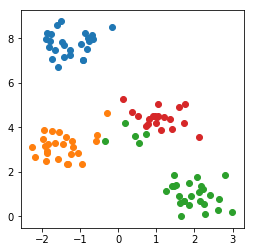

In [686]:
clf = ScratchKMeans(n_iter_1=200, n_iter_2=30, n_neighbors=4)
clf.fit(X)
cluster, sse = clf.predict(X)
clf.plot_result(X, cluster)

## 【問題2】エルボー法の実装
K-meansにおいて中心点の個数 
k
 は人為的に決める必要があるが、その判断方法としてエルボー法があります。

SSEを縦軸、クラスタ数 
k
 を横軸にした折れ線グラフを表示します。

このためにK-meansのインスタンスからはSSEを取得できるようにしてください。


In [677]:
sse = np.zeros((50,))
for i in range(1, 50):
        clf = ScratchKMeans(n_iter_1=200, n_iter_2=30, n_neighbors=i)
        clf.fit(X)
        cluster, sse[i] = clf.predict(X)
sse

array([   0.        , 1193.61988861, 1840.59429394, 1324.07431081,
        127.46794749,   97.20707826,   83.29215735,  272.7179451 ,
         62.57580009,   53.91222408,   71.53618559,   80.86772096,
         43.61279037,   47.65723685,   40.56712647,   30.01153598,
         27.84360705,   39.45740451,   26.92463429,   24.08104081,
         22.64690681,   31.78144823,   22.25279396,   22.25925045,
         64.26168705,   19.88728206,   20.42487325,   14.42258783,
         27.59101065,   19.94944604,   21.63255667,   17.26232705,
         15.52171231,   13.82571128,   16.84030048,   19.54849521,
         13.44376931,   20.34731664,   16.3475131 ,   14.5236165 ,
         10.1740261 ,   12.75527494,    8.40007677,   11.41103205,
          8.70098323,   10.18143328,    9.97715992,   11.06514535,
          9.06874808,   10.48930146])

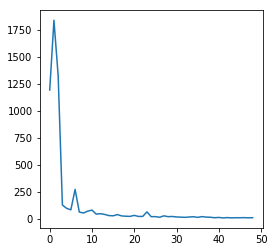

In [680]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = plt.plot(sse[1:], label=i)
plt.show()

## 【問題3】（アドバンス課題）シルエット図
この数式を実装し、シルエット図を確認してください。

## 【問題4】クラスタ数kの選択
最適だと思われるクラスタ数 
k
 を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。



## 【問題5】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

## 【問題6】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

ヒント

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasのgroupbyが便利です。

pandas.DataFrame.groupby — pandas 0.23.4 documentation

## 【問題7】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては DBSCAN 、
PCA以外に次元削減手法で有名な手法としては t-SNE や LLE があります。

DBSCANのメリット・デメリット
t-SNE、LLEのメリット・デメリット
について記述してください。

## 【問題8】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 t-SNE を用いて次元削減をしてください。さらにK-meansではなく、 DBSCAN を用いてクラスタリングしてください。

そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation

sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation

パラメーターチューニング

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

t-SNEの論文

DBSCANの論文

5.ディスカッション

## 【問題9】教師なし学習と教師あり学習
最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。

教師なし学習は教師あり学習とどのような違いがあるか